# Analysis of musical genres across the world
### By Tobias Munch, Jakub Wisniewski and Aleksandra Ludwiniak

In this explainer notebook, we will show you how we have explored our available data and how we have analysed that data. In order to run this notebook, you will need the following files in the same folder as this notebook:
* ids.txt : a file containing a dictionary that maps certain variables to strings containing client ids for both the Spotify and Genius APIs. These ids will not be shared, but you can generate them through the developer sites for both Spotify and Genius. The redirect uri for the Spotify app is not important, and can simply be "https://localhost:8888/callback"
   * {"GENIUS_CLIENT_ID":, "INSERT ID HERE"
     "GENIUS_CLIENT_SECRET": "INSERT ID HERE",
     "GENIUS_ACCESS_TOKEN": "INSERT ID HERE",
     "SPOTIPY_CLIENT_ID": "INSERT ID HERE",
     "SPOTIPY_CLIENT_SECRET": "INSERT ID HERE",
     "SPOTIPY_REDIRECT_URI":"https://localhost:8888/callback"}
     
* Data_Set_S1.txt : a file containing the LabMT dataset, as shown here https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752#pone.0026752.s001
* cities15000.txt : a file containing data from https://www.geonames.org/

With that out of the way, we will get all imports done.

In [1]:
import collections
import copy
import csv
from itertools import combinations
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import powerlaw
import re
import requests
import spotipy
from tqdm import tqdm
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from scipy.cluster.hierarchy import fcluster
from spotipy.oauth2 import SpotifyClientCredentials
from wordcloud import WordCloud, ImageColorGenerator
from networkx.algorithms import community as nx_community
from collections import Counter
import igraph as ig
import community as community_louvain
import scipy.cluster.hierarchy as sch
from itertools import combinations 
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from collections import Counter
import geopy
from geopy.geocoders import Nominatim
import cartopy.crs as ccrs
import folium
import plotly.express as px
from sklearn.metrics import silhouette_score 

C:\Users\tobia\anaconda3\envs\nerf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# to create the network I will create a simple function that gets references from wiki article


In [3]:

def get_references(text):
    pattern = r'\[\[(.*?)\]\]'
    matches = re.findall(pattern, text)

    matches_more = []
    for match in matches:
        x = match.split('|')
        for m in x:
            matches_more.append(m)

    return matches_more

#The function above uses regex to gather everything inside double square brackets `[[]]`. We know that there might be more than one option there so after that we split everything on `|` mark.  

# Creating function to load up the rapper page

def get_wikipage(wiki_name):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    title = f"titles={wiki_name.replace(' ', '_')}" # replacing space with _
    content = "prop=revisions&rvprop=content"
    dataformat ="format=json" # we want have it in json format


    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)


    wikitext = requests.get(query).content.decode('utf-8') # decoding to utf

    d = json.loads(wikitext)

    # now we want the actual latest article from wikipedia,
    # so we have to access this information within dictionaries
    page = d['query']['pages']
    page_id = list(page.keys())[0]
    page_title = page[page_id]['title']
    content = page[page_id]['revisions'][0]['*']

    return page_title, content

# better content
def get_wikipage_content(wiki_name):
    #wiki_name = wiki_name.decode('utf-8')
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    prop="extracts"
    exlimit='1'
    explaintext='1'
    title = f"titles={wiki_name.replace(' ', '_')}"
    content = "prop=extracts&rvprop=content"
    dataformat ="format=json"

    
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    
    
    wikitext = requests.get(query).content.decode('utf-8')
    
    d = json.loads(wikitext)   

    page = d['query']['pages']
    page_id = list(page.keys())[0]
    page_title = page[page_id]['title']
    
    content = page[page_id]['extract']
    pattern = r'<[^>]*>'
    filtered_text = re.sub(pattern, '', content)

    return page_title, filtered_text

In [4]:
page_title, content = get_wikipage('List_of_music_genres_and_styles')
music_list = get_references(content)

In [5]:
to_remove = []
for x in music_list:
    if x + ' (music)' in music_list:
        to_remove.append(x)
    elif x + ' music' in music_list:
        to_remove.append(x)
    elif x + ' in music' in music_list:
        to_remove.append(x)
    elif x + ' (genre)' in music_list:
        to_remove.append(x)
    elif x.startswith("List of"):
        to_remove.append(x)
    elif x.startswith("Category:"):
        to_remove.append(x)
        
for x in to_remove:
    music_list.remove(x)

# First three are "Music", "music genre", and "genres", so we remove those as well
music_list = music_list[3:]

# Finally, we remove all duplicates
music_list = list(set(music_list))


In [6]:
with open ('music_genres.txt', 'w', encoding='utf-8') as f:
    for x in music_list:
        f.writelines(x + '\n')

I then manually go through music genres and manually remove some of the values

In [7]:
with open ('music_genres.txt', 'r', encoding='utf-8') as f:
    genres = f.readlines()
    genres = [x.replace('\n', '') for x in genres]

In [8]:
music_list = [x.replace('\n', '') for x in music_list]

In [9]:
def extract_origins_ner(text):

    tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/camembert-ner-with-dates")
    model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/camembert-ner-with-dates")
    
    nlp = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy="simple")
    result = nlp(text)
    
    dates = []
    places = []
    
    for item in result[0]:
        if item['entity_group'] == 'DATE':
            dates.append(item['word'])
        elif item['entity_group'] == 'LOC':
            places.append(item['word'])
        
    return dates, places

if not os.path.exists("origin_dict.txt"):
    origin_dict = {}

    for genre in better_music_list:
        _,wikipage_test = get_wikipage(genre) #cultural_origins[^|]*
        test_text = get_references(wikipage_test, pattern=r'cultural_origins[^\n]*')
        if test_text != [] and test_text is not None:
            try:
                origin_dict[genre] = extract_origins_ner(test_text)
                print("succeeded with", genre)
                continue
            except:
                print("failed with", genre)
        else:
            print(f'failed to extract origins for {genre}')

    with open('origin_dict.txt', 'w') as convert_file: 
         convert_file.write(json.dumps(origin_dict))
else:
    with open('origin_dict.txt') as f: 
        data = f.read() 
      
    # reconstructing the data as a dictionary 
    js = json.loads(data)

# Initial Network Analysis

In [10]:
Di = nx.DiGraph()
Di.add_nodes_from(genres)

In [11]:
for name in tqdm(genres):

    try:
        # for each name get wikipage
        page_title, content = get_wikipage(name)
        _, clean_content = get_wikipage_content(name)
        Di.nodes[name]['content'] = clean_content
        # for each ref get wikipage
        
        for ref in get_references(content):
            
            # if it is add edge between those
            if ref in genres:
                if ref != name:
                    Di.add_edge(name, ref) 
    except:
        print(f'failed for: {page_title}')

  4%|██▉                                                                             | 56/1555 [00:39<14:04,  1.77it/s]

failed for: Classic female blues


  4%|███▍                                                                            | 67/1555 [00:46<14:29,  1.71it/s]

failed for: Jump blues


  6%|████▋                                                                           | 91/1555 [01:01<13:41,  1.78it/s]

failed for: Bluegrass music


  7%|█████▎                                                                         | 105/1555 [01:09<12:36,  1.92it/s]

failed for: Honky-tonk


  7%|█████▍                                                                         | 107/1555 [01:10<14:33,  1.66it/s]

failed for: Country music


  8%|██████▏                                                                        | 123/1555 [01:20<12:19,  1.94it/s]

failed for: Western music (North America)


 10%|███████▋                                                                       | 152/1555 [01:38<12:15,  1.91it/s]

failed for: Andean new age music


 15%|███████████▍                                                                   | 226/1555 [02:26<14:09,  1.56it/s]

failed for: Musique concrète


 16%|████████████▋                                                                  | 250/1555 [02:44<12:59,  1.67it/s]

failed for: Neue Deutsche Welle


 24%|██████████████████▊                                                            | 370/1555 [04:00<13:10,  1.50it/s]

failed for: Balearic beat


 28%|██████████████████████▎                                                        | 438/1555 [04:42<09:42,  1.92it/s]

failed for: Intelligent dance music


 31%|████████████████████████▊                                                      | 489/1555 [05:14<12:30,  1.42it/s]

failed for: Brostep


 40%|███████████████████████████████▊                                               | 627/1555 [06:48<08:32,  1.81it/s]

failed for: Jazz fusion


 41%|████████████████████████████████▎                                              | 635/1555 [06:52<07:53,  1.94it/s]

failed for: M-Base


 43%|█████████████████████████████████▉                                             | 667/1555 [07:11<07:31,  1.96it/s]

failed for: Brill Building (genre)


 49%|██████████████████████████████████████▌                                        | 760/1555 [08:13<06:45,  1.96it/s]

failed for: Yé-yé


 49%|██████████████████████████████████████▋                                        | 761/1555 [08:13<05:45,  2.30it/s]

failed for: Yé-yé


 74%|█████████████████████████████████████████████████████████▌                    | 1148/1555 [12:36<03:46,  1.79it/s]

failed for: Pashto music


 74%|█████████████████████████████████████████████████████████▋                    | 1149/1555 [12:36<03:11,  2.12it/s]

failed for: Pashto music


 74%|█████████████████████████████████████████████████████████▋                    | 1150/1555 [12:36<03:01,  2.23it/s]

failed for: Pashto music


 74%|█████████████████████████████████████████████████████████▋                    | 1151/1555 [12:37<02:34,  2.61it/s]

failed for: Pashto music


 74%|█████████████████████████████████████████████████████████▊                    | 1152/1555 [12:37<02:31,  2.66it/s]

failed for: Pashto music


 74%|█████████████████████████████████████████████████████████▉                    | 1155/1555 [12:39<03:38,  1.83it/s]

failed for: Tuvan throat singing


 75%|██████████████████████████████████████████████████████████▎                   | 1162/1555 [12:44<04:19,  1.51it/s]

failed for: Chinese hip hop


 78%|█████████████████████████████████████████████████████████████▏                | 1219/1555 [13:22<02:33,  2.19it/s]

failed for: String (Thai pop)


 79%|█████████████████████████████████████████████████████████████▎                | 1222/1555 [13:24<02:46,  2.00it/s]

failed for: Original Pilipino Music


 91%|███████████████████████████████████████████████████████████████████████▏      | 1418/1555 [15:38<01:06,  2.06it/s]

failed for: Cumbia


100%|█████████████████████████████████████████████████████████████████████████████▊| 1551/1555 [17:08<00:01,  2.17it/s]

failed for: Simon Frith


100%|██████████████████████████████████████████████████████████████████████████████| 1555/1555 [17:10<00:00,  1.51it/s]


In [12]:
G = Di.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G)) # sanity check

In [13]:
nx.write_graphml(Di, 'directed.graphml')

In [14]:
nx.write_graphml(G, 'undirected.graphml')

In [15]:
G = nx.read_graphml('undirected.graphml')
D = nx.read_graphml('directed.graphml')

In [16]:
pos = nx.kamada_kawai_layout(G,scale=5)
degrees = [G.degree[node] for node in G.nodes()]

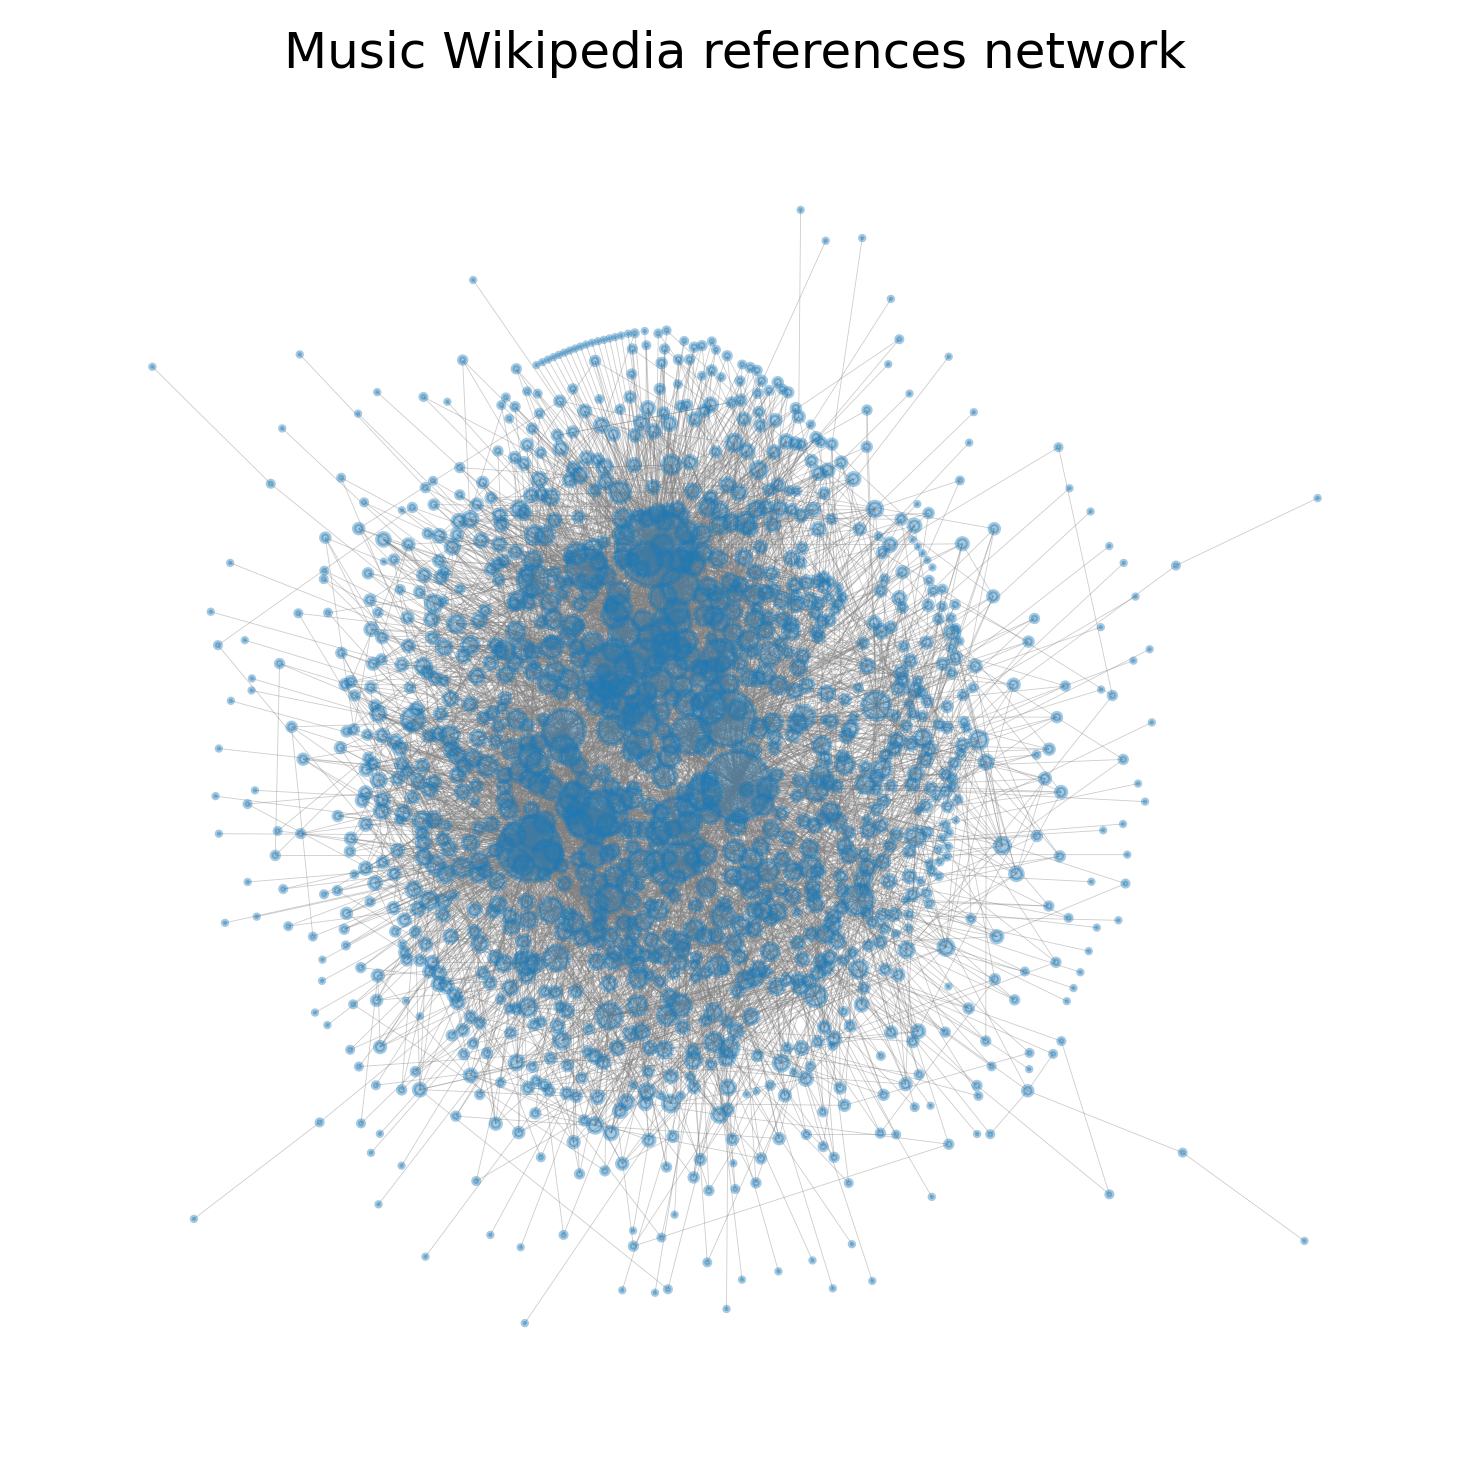

In [17]:

fig = plt.figure(1, figsize=(5, 5), dpi=300)

plt.title('Music Wikipedia references network')
nx.draw(G, 
        pos,
       width = 0.2,
       with_labels=False,
       #node_color=color_map,
       node_size = degrees,
       edge_color='gray',
       alpha=0.4, 
    )

plt.tight_layout()
plt.savefig("Graph.png", format="PNG")


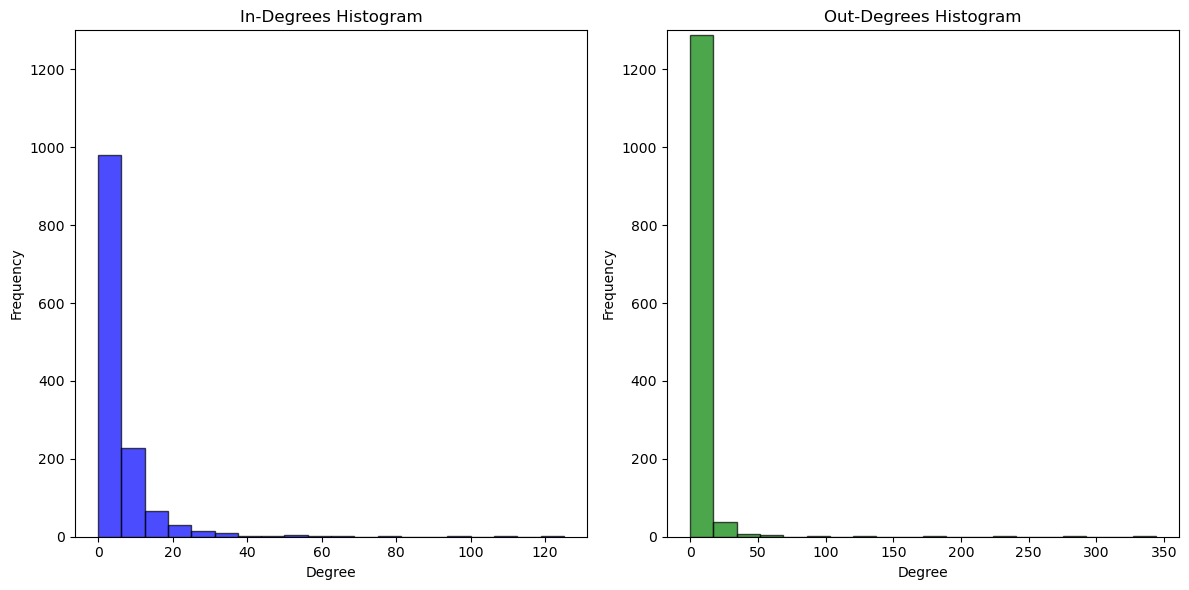

<Figure size 640x480 with 0 Axes>

In [18]:

# Calculate in-degrees and out-degrees
in_degrees = dict(D.in_degree())
out_degrees = dict(D.out_degree())

# Plot the histograms
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.hist(list(in_degrees.values()), bins=20, alpha=0.7, color='b', edgecolor='black')
plt.title('In-Degrees Histogram')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.ylim(0, 1300) # limiting the scale

plt.subplot(122)
plt.hist(list(out_degrees.values()), bins=20, alpha=0.7, color='g', edgecolor='black')
plt.title('Out-Degrees Histogram')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.ylim(0, 1300) # limiting the scale

plt.tight_layout()
plt.show()
plt.savefig('in-out-deg.')

 minumum degree: 0
 maximum degree: 345


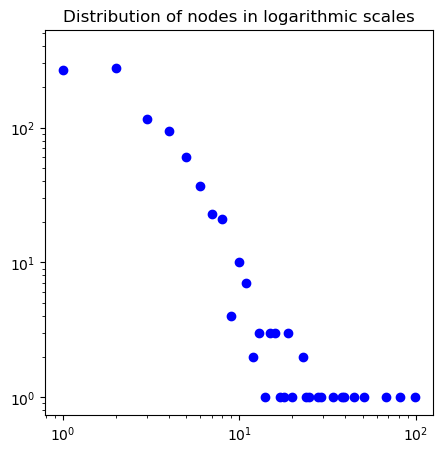

In [19]:
list_degree=list(G.degree())
nodes , degree = map(list, zip(*list_degree))
print(f" minumum degree: {np.min(degree)}")
print(f" maximum degree: {np.max(degree)}")


hist, bin_edges = np.histogram(degree, bins=100, density=False)
#fig, axs = plt.subplots(1,2, figsize=(5,5))
plt.figure(figsize=(5,5))
plt.plot(hist, 'bo')
plt.xscale('log')
plt.yscale('log')
plt.title("Distribution of nodes in logarithmic scales")
plt.savefig('distribution.png')
plt.show()


In [20]:
in_degrees = np.array([x[1] for x in D.in_degree])
out_degrees = np.array([x[1] for x in D.out_degree])

In [21]:
powerlaw.Fit(list(in_degrees)).alpha

Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


3.2149101739272083

In [22]:
powerlaw.Fit(list(out_degrees)).alpha

Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


3.0398784927945495

# Further analysis 

In [23]:
D = nx.read_graphml('directed.graphml')

In [24]:
len(D.nodes)

1344

In [25]:
len(D.edges)

7866

In [26]:
#print(D.nodes['Techno']['content'])


Techno is a genre of electronic dance music (EDM) which is generally produced for use in a continuous DJ set, with tempo often varying between 120 and 150 (as per Marcello Perri) beats per minute (bpm). The central rhythm is typically in common time (4/4) and often characterized by a repetitive four on the floor beat. Artists may use electronic instruments such as drum machines, sequencers, and synthesizers, as well as digital audio workstations. Drum machines from the 1980s such as Roland's TR-808 and TR-909 are highly prized, and software emulations of such retro instruments are popular.
Much of the instrumentation in techno emphasizes the role of rhythm over other musical parameters. Techno tracks mainly progress over manipulation of timbral characteristics of synthesizer presets and, unlike forms of EDM that tend to be produced with synthesizer keyboards, techno does not always strictly adhere to the harmonic practice of Western music and such structures are often ignored in favor

# COMMUNITIES

In [27]:
G = nx.read_graphml('undirected.graphml')

To study communities we implemented three algorithms: Girvan-Newman, FastGreedy and Louvain.

## Girvan-Newman

Modularity of the network: 0.005881632167478081


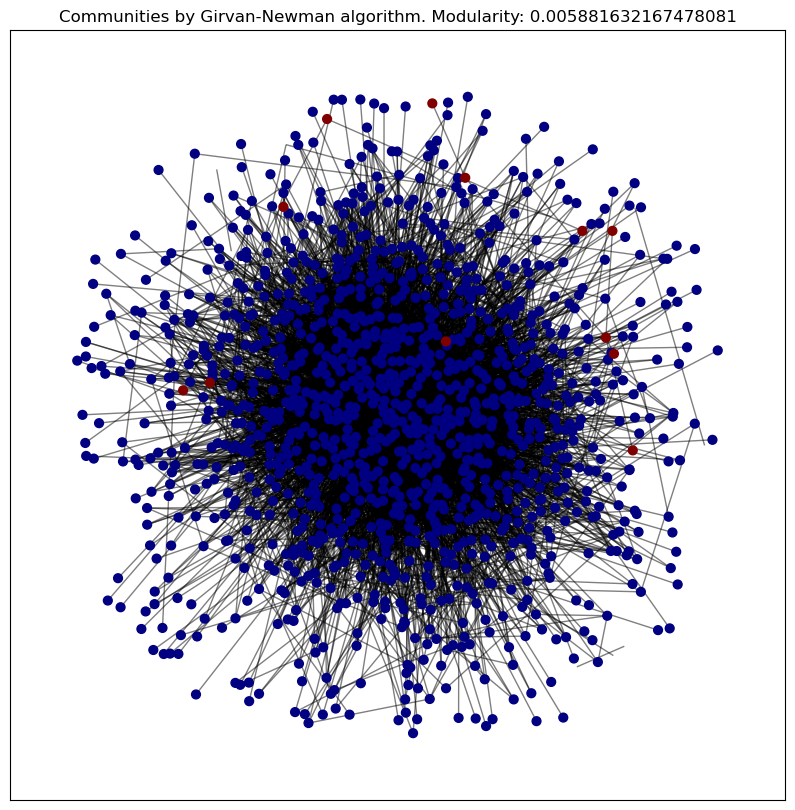

Number of communities after filtering: 2
Community 0: Size 1238
Community 23: Size 12


In [28]:
# Girvan-Newman algorithm
communities_generator = nx_community.girvan_newman(G)

num_levels = 4 
for _ in range(num_levels):
    next_level_communities = next(communities_generator)

partition = {node: cid for cid, community in enumerate(next_level_communities) for node in community}

# calculate and print modularity with the current level of partition
modularity = nx_community.modularity(G, next_level_communities)
print(f"Modularity of the network: {modularity}")

# count the sizes of each community
community_sizes = Counter(partition.values())

# filter out communities with 1 or 2 nodes only for visualization purposes
filtered_partition = {node: community for node, community in partition.items() if community_sizes[community] > 2}

# visualize the graph without small communities
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=0.15, iterations=20)
cmap = plt.cm.jet

nx.draw_networkx_nodes(G, pos, filtered_partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(filtered_partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title(f"Communities by Girvan-Newman algorithm. Modularity: {modularity}")
plt.savefig('community_girvan_newman.jpg', format='jpg')
plt.show()
# print information about communities after filtering
filtered_community_sizes = Counter(filtered_partition.values())
print("Number of communities after filtering:", len(filtered_community_sizes))
for community, size in filtered_community_sizes.items():
    print(f"Community {community}: Size {size}")

In the case of the Girvan-Newman algorithm, we were unable to obtain a division other than a highly clustered subgraph containing the vast majority of vertices as main communities and many communities containing one or two vertices each. After filtering communities containing 1 or 2 vertices, we obtained the above results. We used this algorithm for different level configurations, but the results did not differ significantly between levels and, moreover, it was computationally incriminating.

## FastGreedy

Modularity of the network: 0.40640303757817686


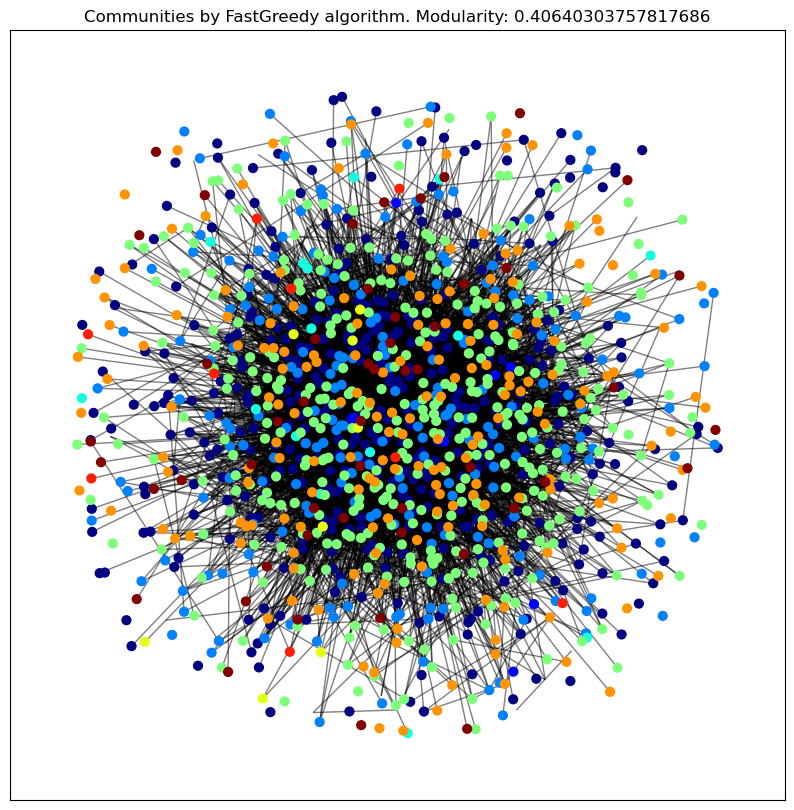

Community 0: Size 388, Strength: 0.01, Central Node: music genre
Community 1: Size 7, Strength: 0.05, Central Node: Psychedelic music
Community 2: Size 218, Strength: 0.01, Central Node: Heavy metal music
Community 3: Size 15, Strength: 0.01, Central Node: Deathcore
Community 4: Size 369, Strength: 0.01, Central Node: Hip hop music
Community 5: Size 8, Strength: 0.00, Central Node: Alegrías
Community 6: Size 189, Strength: 0.01, Central Node: New wave music
Community 7: Size 9, Strength: 0.00, Central Node: Honky Tonk Blues
Community 8: Size 51, Strength: 0.01, Central Node: Reggae


In [29]:
# FastGreedy community
nxG = G
g = ig.Graph.TupleList(nxG.edges(), directed=False)
index_to_label = {index: label for index, label in enumerate(nxG.nodes())}

dendrogram = g.community_fastgreedy()
clusters = dendrogram.as_clustering()
partition = {index_to_label[index]: cid for cid, community in enumerate(clusters) for index in community}

# calculate modularity 
modularity = clusters.modularity
print(f"Modularity of the network: {modularity}")

# count the sizes of each community
community_sizes = Counter(partition.values())

# calculate community strength and central node for each community
community_strength = {}
central_nodes = {}

for community in set(partition.values()):
    subgraph_nodes = [node for node, comm in partition.items() if comm == community]
    subgraph = nxG.subgraph(subgraph_nodes)
    internal_edges = subgraph.number_of_edges()
    possible_edges = len(subgraph) * (len(subgraph) - 1) / 2
    community_strength[community] = internal_edges / possible_edges if possible_edges > 0 else 0

    degree_centrality = nx.degree_centrality(subgraph)
    central_node = max(degree_centrality, key=degree_centrality.get)
    central_nodes[community] = central_node

# filter out communities with 1 or 2 nodes only for visualization purposes
filtered_partition = {node: community for node, community in partition.items() if community_sizes[community] > 2}

# visualize the graph without small communities
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(nxG, k=0.15, iterations=20)
cmap = plt.cm.jet

# use correct node labels for plotting
nx.draw_networkx_nodes(nxG, pos, nodelist=filtered_partition.keys(), node_size=40,
                       cmap=cmap, node_color=[filtered_partition[node] for node in filtered_partition.keys()])
nx.draw_networkx_edges(nxG, pos, alpha=0.5)
plt.title(f"Communities by FastGreedy algorithm. Modularity: {modularity}")
plt.savefig('community_fastgreedy.jpg', format='jpg')
plt.show()

# print information for each community
for community in set(filtered_partition.values()):
    size = community_sizes[community]
    strength = community_strength[community]
    central_node = central_nodes[community]

    print(f"Community {community}: Size {size}, Strength: {strength:.2f}, Central Node: {central_node}")

The implementation of FastGreddy resulted in 7 communities that have the number of vertices above 2. To check the quality of this division, we checked the modularity, strength and main hubs. Modularity was almost 0.4, which indicates a good division, but the strength of connections in subsequent communities may mean that this division is not optimal, or there is no clear difference in the number of connections inside and outside communities.

## Louvain

In [30]:
# louvain - communities
partition = community_louvain.best_partition(G)

# calculate modularity
modularity = community_louvain.modularity(partition, G)
print(f"Modularity of the network: {modularity}")

# sizes of each community
community_sizes = Counter(partition.values())

# calculate community strength and central node for each community
community_strength = {}
central_nodes = {}

for community in set(partition.values()):
    subgraph = G.subgraph([node for node, comm in partition.items() if comm == community])
    internal_edges = subgraph.number_of_edges()
    possible_edges = len(subgraph) * (len(subgraph) - 1) / 2
    community_strength[community] = internal_edges / possible_edges if possible_edges > 0 else 0

    # Degree centrality for central node
    degree_centrality = nx.degree_centrality(subgraph)
    central_node = max(degree_centrality, key=degree_centrality.get)
    central_nodes[community] = central_node

# filter out communities with 1 or 2 nodes only for visualization purposes
filtered_partition = {node: community for node, community in partition.items() if community_sizes[community] > 2}

# visualize the graph without small communities
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=0.15, iterations=20)
cmap = plt.cm.jet

nx.draw_networkx_nodes(G, pos, filtered_partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(filtered_partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title(f"Communities by louvian algorithm. Modularity: {modularity}")
plt.savefig('community_louvian.jpg', format='jpg')
plt.show()

filtered_community_sizes = Counter(filtered_partition.values())
print("Number of communities after filtering:", len(filtered_community_sizes))

# print information for each community
for community in set(filtered_partition.values()):
    size = community_sizes[community]
    strength = community_strength[community]
    central_node = central_nodes[community]

    print(f"Community {community}: Size {size}, Strength: {strength:.2f}, Central Node: {central_node}")

AttributeError: module 'community' has no attribute 'best_partition'

The implementation of the Louvain algorithm resulted in 9 communities with the number of vertices above 2. To check the quality of this division, we checked the modularity, strength and main hubs. Modularity was approximately 0.45, which indicates a very good division, and we also obtained much better results in terms of the strength of connections between vertices in individual communities. Displaying the hubs allowed us to find out what values our communities are focused on.

# Hierarchical clustering

Number of all clusters identified: 63 - distance_threshold: 2.0
Number of clusters identified (excluding single-node and double-node clusters): 38
Cluster 27: Number of vertices: 50, Central node: genres
Cluster 4: Number of vertices: 101, Central node: Andalusian classical music
Cluster 17: Number of vertices: 12, Central node: Indian classical music
Cluster 6: Number of vertices: 120, Central node: Korean court music
Cluster 24: Number of vertices: 70, Central node: Western classical music
Cluster 1: Number of vertices: 92, Central node: Early music
Cluster 36: Number of vertices: 19, Central node: Medieval music
Cluster 5: Number of vertices: 92, Central node: Ars antiqua
Cluster 23: Number of vertices: 77, Central node: Bardcore
Cluster 25: Number of vertices: 81, Central node: Neo-Medieval music
Cluster 35: Number of vertices: 18, Central node: Renaissance music
Cluster 21: Number of vertices: 4, Central node: Baroque music
Cluster 37: Number of vertices: 18, Central node: Classic

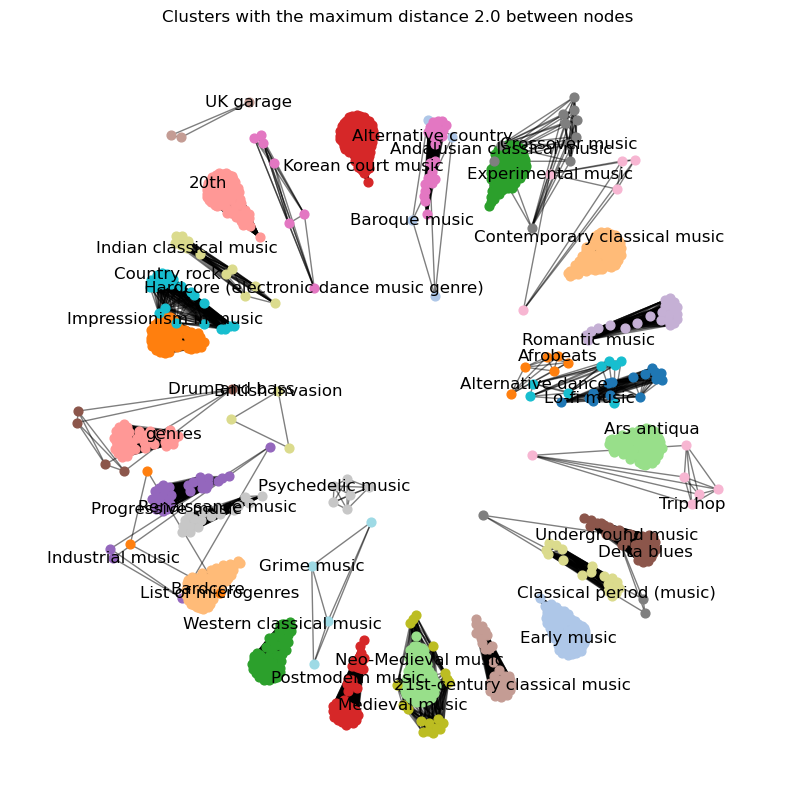

The average silhouette_score is : 0.9753919133941457


UnicodeEncodeError: 'charmap' codec can't encode character '\u014d' in position 3: character maps to <undefined>

In [35]:
nodes = list(G.nodes())
features = []

for node in nodes:
    degree = G.degree(node)
    centrality = nx.degree_centrality(G)[node]
    features.append([degree, centrality])

feature_matrix = np.array(features)
Z = sch.linkage(feature_matrix, method='ward')


distance_threshold = 2.0
clusters = fcluster(Z, distance_threshold, criterion='distance')

# all clusters
all_clusters = {node: cluster for node, cluster in zip(G.nodes(), clusters) if list(clusters).count(cluster)}

# assign clusters to nodes, skipping clusters with only one and two nodes
cluster_dict = {node: cluster for node, cluster in zip(G.nodes(), clusters) if list(clusters).count(cluster) > 2}

# create a new graph for visualization
visG = nx.Graph()

# add edges to make sure all nodes in each cluster are connected
for cluster in set(cluster_dict.values()):
    nodes_in_cluster = [node for node, clust in cluster_dict.items() if clust == cluster]
    for node1, node2 in combinations(nodes_in_cluster, 2):
        visG.add_edge(node1, node2)

# calculate degree centrality for each node in the original graph
degree_centrality = nx.degree_centrality(G)

# find the most important node in each cluster of the original graph
important_nodes = {}
for node, cluster in cluster_dict.items():
    if cluster not in important_nodes:
        important_nodes[cluster] = node
    elif degree_centrality[node] > degree_centrality[important_nodes[cluster]]:
        important_nodes[cluster] = node

# Count the number of vertices in each cluster
cluster_counts = Counter(cluster_dict.values())

# print the most important nodes for each cluster
num_clusters = len(set(all_clusters.values()))
print(f"Number of all clusters identified: {num_clusters} - distance_threshold: {distance_threshold}")
num_clusters = len(set(cluster_dict.values()))
print(f"Number of clusters identified (excluding single-node and double-node clusters): {num_clusters}")
for cluster, node in important_nodes.items():
    print(f"Cluster {cluster}: Number of vertices: {cluster_counts[cluster]}, Central node: {node}")

# calculate layout for the visualization graph with increased edge length
pos = nx.spring_layout(visG, k=0.2)

# draw the graph
plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(visG, pos, alpha=0.5)

# draw nodes with different colors for each cluster in the visualization graph
palette = plt.cm.tab20.colors 
for cluster_id in set(cluster_dict.values()):
    nx.draw_networkx_nodes(
        visG, pos,
        nodelist=[node for node, cluster in cluster_dict.items() if cluster == cluster_id],
        node_size=40,
        node_color=[palette[cluster_id % len(palette)]]
    )

# label the central nodes
central_node_labels = {node: node for node in important_nodes.values()}
nx.draw_networkx_labels(visG, pos, labels=central_node_labels, font_color='black')

plt.title(f"Clusters with the maximum distance {distance_threshold} between nodes")
plt.axis('off')
plt.savefig('clusters_visualization.jpg', format='jpg')
plt.show()


silhouette_avg = silhouette_score(feature_matrix, clusters)
print("The average silhouette_score is :", silhouette_avg)


# save the cluster information and positions to CSV files
with open('clusters.csv', 'w', newline='') as csvfile:
    fieldnames = ['node', 'cluster']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for node, cluster in cluster_dict.items():
        writer.writerow({'node': node, 'cluster': cluster})

with open('clusters_positions.csv', 'w', newline='') as csvfile:
    fieldnames = ['node', 'pos_x', 'pos_y']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for node, position in pos.items():
        writer.writerow({'node': node, 'pos_x': position[0], 'pos_y': position[1]})

The Silhouette index, which measures how well each point fits into its cluster compared to other clusters, shows a value close to 1, which indicates very good clustering.

In [ ]:
nodes = list(G.nodes())
features = []

for node in nodes:
    degree = G.degree(node)
    centrality = nx.degree_centrality(G)[node]
    features.append([degree, centrality])

feature_matrix = np.array(features)
Z = sch.linkage(feature_matrix, method='ward')


distance_threshold = 2.0
clusters = fcluster(Z, distance_threshold, criterion='distance')

# all clusters
all_clusters = {node: cluster for node, cluster in zip(G.nodes(), clusters) if list(clusters).count(cluster)}

# assign clusters to nodes, skipping clusters with only one and two nodes
cluster_dict = {node: cluster for node, cluster in zip(G.nodes(), clusters) if list(clusters).count(cluster) > 2}

# create a new graph for visualization
visG = nx.Graph()

# add edges to make sure all nodes in each cluster are connected
for cluster in set(cluster_dict.values()):
    nodes_in_cluster = [node for node, clust in cluster_dict.items() if clust == cluster]
    for node1, node2 in combinations(nodes_in_cluster, 2):
        visG.add_edge(node1, node2)

# calculate degree centrality for each node in the original graph
degree_centrality = nx.degree_centrality(G)

# find the most important node in each cluster of the original graph
important_nodes = {}
for node, cluster in cluster_dict.items():
    if cluster not in important_nodes:
        important_nodes[cluster] = node
    elif degree_centrality[node] > degree_centrality[important_nodes[cluster]]:
        important_nodes[cluster] = node

# Count the number of vertices in each cluster
cluster_counts = Counter(cluster_dict.values())

# print the most important nodes for each cluster
num_clusters = len(set(all_clusters.values()))
print(f"Number of all clusters identified: {num_clusters} - distance_threshold: {distance_threshold}")
num_clusters = len(set(cluster_dict.values()))
print(f"Number of clusters identified (excluding single-node and double-node clusters): {num_clusters}")
for cluster, node in important_nodes.items():
    print(f"Cluster {cluster}: Number of vertices: {cluster_counts[cluster]}, Central node: {node}")

# calculate layout for the visualization graph with increased edge length
pos = nx.spring_layout(visG, k=0.2)

# draw the graph
plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(visG, pos, alpha=0.5)

# draw nodes with different colors for each cluster in the visualization graph
palette = plt.cm.tab20.colors 
for cluster_id in set(cluster_dict.values()):
    nx.draw_networkx_nodes(
        visG, pos,
        nodelist=[node for node, cluster in cluster_dict.items() if cluster == cluster_id],
        node_size=40,
        node_color=[palette[cluster_id % len(palette)]]
    )

# label the central nodes
central_node_labels = {node: node for node in important_nodes.values()}
nx.draw_networkx_labels(visG, pos, labels=central_node_labels, font_color='black')

plt.title(f"Clusters with the maximum distance {distance_threshold} between nodes")
plt.axis('off')
plt.savefig('clusters_visualization.jpg', format='jpg')
plt.show()

# Calculate the Silhouette score
silhouette_avg = silhouette_score(feature_matrix, clusters)
print("The average silhouette_score is :", silhouette_avg)

# save the cluster information and positions to CSV files
with open('clusters.csv', 'w', newline='') as csvfile:
    fieldnames = ['node', 'cluster']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for node, cluster in cluster_dict.items():
        writer.writerow({'node': node, 'cluster': cluster})

with open('clusters_positions.csv', 'w', newline='') as csvfile:
    fieldnames = ['node', 'pos_x', 'pos_y']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for node, position in pos.items():
        writer.writerow({'node': node, 'pos_x': position[0], 'pos_y': position[1]})

In [ ]:
# creating a histogram of the number of nodes in clusters
cluster_sizes = sorted(cluster_counts.values(), reverse=True)  # Sorting from largest to smallest cluster
plt.figure(figsize=(10, 6))
plt.bar(range(len(cluster_sizes)), cluster_sizes)
plt.xlabel('Cluster Number')
plt.ylabel('Number of Nodes in Cluster')
plt.title(f"Clusters with the maximum distance {distance_threshold} between nodes")
plt.show()

In [ ]:
distance_threshold = 3.0
clusters = fcluster(Z, distance_threshold, criterion='distance')

# all clusters
all_clusters = {node: cluster for node, cluster in zip(G.nodes(), clusters) if list(clusters).count(cluster)}

# assign clusters to nodes, skipping clusters with only one and two nodes
cluster_dict = {node: cluster for node, cluster in zip(G.nodes(), clusters) if list(clusters).count(cluster) > 2}

# create a new graph for visualization
visG = nx.Graph()

# add edges to make sure all nodes in each cluster are connected
for cluster in set(cluster_dict.values()):
    nodes_in_cluster = [node for node, clust in cluster_dict.items() if clust == cluster]
    for node1, node2 in combinations(nodes_in_cluster, 2):
        visG.add_edge(node1, node2)

# calculate degree centrality for each node in the original graph
degree_centrality = nx.degree_centrality(G)

# find the most important node in each cluster of the original graph
important_nodes = {}
for node, cluster in cluster_dict.items():
    if cluster not in important_nodes:
        important_nodes[cluster] = node
    elif degree_centrality[node] > degree_centrality[important_nodes[cluster]]:
        important_nodes[cluster] = node

# Count the number of vertices in each cluster
cluster_counts = Counter(cluster_dict.values())

# print the most important nodes for each cluster
num_clusters = len(set(all_clusters.values()))
print(f"Number of all clusters identified: {num_clusters} - distance_threshold: {distance_threshold}")
num_clusters = len(set(cluster_dict.values()))
print(f"Number of clusters identified (excluding single-node and double-node clusters): {num_clusters}")
for cluster, node in important_nodes.items():
    print(f"Cluster {cluster}: Number of vertices: {cluster_counts[cluster]}, Central node: {node}")
    
# Calculate the Silhouette score
silhouette_avg = silhouette_score(feature_matrix, clusters)
print("The average silhouette_score is :", silhouette_avg)

In [ ]:
# creating a histogram of the number of nodes in clusters
cluster_sizes = sorted(cluster_counts.values(), reverse=True)  # sorting from largest to smallest cluster
plt.figure(figsize=(10, 6))
plt.bar(range(len(cluster_sizes)), cluster_sizes)
plt.xlabel('Cluster Number')
plt.ylabel('Number of Nodes in Cluster')
plt.title(f"Clusters with the maximum distance {distance_threshold} between nodes")
plt.show()

In [ ]:
distance_threshold = 5.0
clusters = fcluster(Z, distance_threshold, criterion='distance')

# all clusters
all_clusters = {node: cluster for node, cluster in zip(G.nodes(), clusters) if list(clusters).count(cluster)}

# assign clusters to nodes, skipping clusters with only one and two nodes
cluster_dict = {node: cluster for node, cluster in zip(G.nodes(), clusters) if list(clusters).count(cluster) > 2}

# create a new graph for visualization
visG = nx.Graph()

# add edges to make sure all nodes in each cluster are connected
for cluster in set(cluster_dict.values()):
    nodes_in_cluster = [node for node, clust in cluster_dict.items() if clust == cluster]
    for node1, node2 in combinations(nodes_in_cluster, 2):
        visG.add_edge(node1, node2)

# calculate degree centrality for each node in the original graph
degree_centrality = nx.degree_centrality(G)

# find the most important node in each cluster of the original graph
important_nodes = {}
for node, cluster in cluster_dict.items():
    if cluster not in important_nodes:
        important_nodes[cluster] = node
    elif degree_centrality[node] > degree_centrality[important_nodes[cluster]]:
        important_nodes[cluster] = node

# Count the number of vertices in each cluster
cluster_counts = Counter(cluster_dict.values())

# print the most important nodes for each cluster
num_clusters = len(set(all_clusters.values()))
print(f"Number of all clusters identified: {num_clusters} - distance_threshold: {distance_threshold}")
num_clusters = len(set(cluster_dict.values()))
print(f"Number of clusters identified (excluding single-node and double-node clusters): {num_clusters}")
for cluster, node in important_nodes.items():
    print(f"Cluster {cluster}: Number of vertices: {cluster_counts[cluster]}, Central node: {node}")
    
# Calculate the Silhouette score
silhouette_avg = silhouette_score(feature_matrix, clusters)
print("The average silhouette_score is :", silhouette_avg)

In [ ]:
# creating a histogram of the number of nodes in clusters
cluster_sizes = sorted(cluster_counts.values(), reverse=True)  # Sorting from largest to smallest cluster
plt.figure(figsize=(10, 6))
plt.bar(range(len(cluster_sizes)), cluster_sizes)
plt.xlabel('Cluster Number')
plt.ylabel('Number of Nodes in Cluster')
plt.title(f"Clusters with the maximum distance {distance_threshold} between nodes")
plt.show()

# Sentiment Analysis across music genres
In this section we will perform sentiment analysis on the top songs of each genre. These genres are given in the *music_genre.txt* file, and in order to get the top songs and their lyrics we will use both the Spotify API through the *spotipy* package for searching and the Genius API through the *lyricsgenius* package to get lyrics.

First of all, we prepare the client IDs for both the Spotify and Genius APIs. The *ids.txt* will not be provided unless given, but can easily be made by accessing the Spotify and Genius developer pages, requesting new IDs, and inserting them in the text file. The SPOTIPY_REDIRECT_URI should be *https://localhost:8888/callback*

In [39]:
with open('ids.txt') as f: 
    data = f.read() 
      
# reconstructing the data as a dictionary 
api_ips = json.loads(data)

SPOTIPY_CLIENT_ID = api_ips['SPOTIPY_CLIENT_ID']
SPOTIPY_CLIENT_SECRET = api_ips['SPOTIPY_CLIENT_SECRET']
SPOTIPY_REDIRECT_URI = api_ips['SPOTIPY_REDIRECT_URI']

GENIUS_CLIENT_ID = api_ips['GENIUS_CLIENT_ID']
GENIUS_CLIENT_SECRET = api_ips['GENIUS_CLIENT_SECRET']
GENIUS_ACCESS_TOKEN = api_ips['GENIUS_ACCESS_TOKEN']

os.environ['SPOTIPY_CLIENT_ID'] = SPOTIPY_CLIENT_ID
os.environ['SPOTIPY_CLIENT_SECRET'] = SPOTIPY_CLIENT_SECRET

Once the API client IDs are defined, we can begin reading the list of genres from the file *"music_genres.txt"*. We read one line at a time, in order to remove the newline symbol from the end of each line.

In [40]:
genres = []
with open ('music_genres_new.txt', 'r', encoding='utf-8') as f:
    while True:
        line = f.readline()

        # if line is empty
        # end of file is reached
        if not line:
            break

        genres.append(line[:-1])
print(genres[:10])

['Andalusian classical music', 'Indian classical music', 'Korean court music', 'Persian classical music', 'Western classical music', 'Early music', 'Medieval music', 'Ars antiqua', 'Ars nova', 'Ars subtilior']


Now we can begin working with the APIs! First of all we define a function that takes a genre and outputs a formattet version of that genre fit for search using the Spotify API. Additionally, we test how the API works with the *spotipy* package.

In [41]:
def genre_to_search_term(genre_name, version=2):
    match version:
        case 1:
            # First attempt at mapping genres to sentiments. Did not seem to get top results
            return "genre%:" + genre_name.replace(" ", "%20") # version 1
        case 2:
            # Second attempt at mapping genres to sentiments. Seems to work better, no weird songs in the searches
            return genre_name.replace(" ", "%20") # version 2
        case _:
            return None

spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

for i in range(1,3):
    results = spotify.search(q=genre_to_search_term(genres[0], version=i), limit=5)
    names = [(result['name'], result['artists'][0]['name'])  for result in results['tracks']['items']]
    print(names)

[('Andalusian Dance', 'Global Village Players'), ('Andalusian Folk Song', 'Unspecified'), ('Andalusian Guitar', 'Colima'), ('Andalusian Nights', 'Govi'), ('Andalusian Muwashah Uthkurini', 'Afif Alvarez Bulos')]
[('Andalusian Dance', 'Global Village Players'), ('Andalusian Muwashah Uthkurini', 'Afif Alvarez Bulos'), ('Andalusian Guitar', 'Colima'), ('Andalusian Nights', 'Govi'), ('Andalusian Folk Song', 'Unspecified')]


Now that we can extract the songs and the artists, we will create a dictionary that maps a genre to the name and artist of the top 5 search items. One thing that we have to take into account is that some of the will end up being unspecified, as shown in the third result with "Andalusian Folk Song". This will complicate things once we have to use the Genius API, but we will handle that.

In [45]:
genre_to_track = {}
TRACKS_PER_GENRE = 5
for genre in tqdm(genres):
    if genre is None:
        continue
    results = spotify.search(q=genre_to_search_term(genre), limit=TRACKS_PER_GENRE)
    if results is None or None in results:
        continue
    genre_to_track[genre] = [(result['name'], result['artists'][0]['name'])  for result in results['tracks']['items']]
    
genre_to_track[genres[20]]

 50%|███████████████████████████████████████▏                                       | 763/1538 [02:19<02:21,  5.46it/s]


ConnectionError: HTTPSConnectionPool(host='api.spotify.com', port=443): Read timed out.

Now we can extract the lyrics of the search results. First of all we create a function that takes a list similar to the ones in *genre_to_track*, and returns a list with the song lyrics if possible. Since there is a risk of the Genius API failing to respond, we use while loops to repeat the API call until it succeeds.

In [ ]:
def extract_lyric_list(track_list):
    genius_api = lyricsgenius.Genius(GENIUS_ACCESS_TOKEN, verbose=False)
    results = []
    for track, artist in track_list:
        while True:
            try: #Retry the request until it goes through
                results.append(genius_api.search_song(track, artist))
                break
            except:
                pass
    return results
        
songs = extract_lyric_list(genre_to_track[genres[0]])

Now we make another function that takes the previous list of songs, and calculates an average sentiment score of those songs

In [ ]:
def labMT_to_dict(path):
    df = pd.read_csv(path,sep='\t',skiprows=(0,1),header=(0))
    df = df.set_index('word').T
    d = df.iloc[1].to_dict()
    return d

print("Creating dictionary from labMT dataset...")
d = labMT_to_dict("Data_Set_S1.txt")
print("Done!")

def calculate_sentiment(d, tokens):
    '''
    INPUT:
    d: dictionary mapping words to sentiment scores
    tokens: list of tokens

    OUTPUT:
    float of overall sentiment score for list
    '''
    score = 0.0
    for token in tokens:
        try:
            score += d[token]
        except:
            # In case token does not exist in dictionary
            continue
    if len(tokens) != 0:
        return score/len(tokens)
    return None

def calc_sentiment_of_genre(songs, no_none=False):
    avg_senti = 0.0
    not_none_length = sum(1 for item in songs if item is not None)
    if no_none and not_none_length != TRACKS_PER_GENRE:
        return -1.0
    for song in songs:
        if song is None:
            continue
        else:
            # Calculate sentiment score
            tokens = word_tokenize(song.lyrics)
            tokens = [x.lower() for x in tokens]
            r = re.compile("\w+")
            tokens = list(filter(r.match, tokens))

            sentiment_score = calculate_sentiment(d, tokens)
            # Add it to avg_senti
            if sentiment_score != None:
                avg_senti += sentiment_score / not_none_length
                
    if avg_senti <= 0.0:
        # If no sentiment was calculated, indicate lack of lyrics with -1
        return -1.0
    return avg_senti
            
def genre_sentiment(genres, genre_to_track):
    genre_sentiments = {}
    for genre in tqdm(genres, position=0, leave=True):
        songs = extract_lyric_list(genre_to_track[genre])
        genre_sentiments[genre] = calc_sentiment_of_genre(songs)
        
    return genre_sentiments

if !os.path.exists("genre_sentiments.txt"):
    genre_sentiments = genre_sentiment(genres, genre_to_track)
    with open('genre_sentiments.txt', 'w') as convert_file: 
        convert_file.write(json.dumps(genre_sentiments))
else: 
    with open('genre_sentiments.txt') as f: 
    data = f.read() 
    # reconstructing the data as a dictionary 
    genre_sentiments = json.loads(data)

In [ ]:
def get_top_and_bottom(my_dict, n, min_value=None, max_value=None):
    # Filter dictionary items based on the specified range
    filtered_items = [(key, value) for key, value in my_dict.items() if (min_value is None or value >= min_value) and (max_value is None or value <= max_value)]

    # Get the top N values
    top_items = sorted(filtered_items, key=lambda item: item[1], reverse=True)[:n]

    # Get the bottom N values
    bottom_items = sorted(filtered_items, key=lambda item: item[1])[:n]

    # Extract keys and values for the top and bottom N items
    top_keys, top_values = zip(*top_items)
    bottom_keys, bottom_values = zip(*bottom_items)

    return top_keys, top_values, bottom_keys, bottom_values

n=5
min_value=0.1
max_value=None
top_keys, top_values, bottom_keys, bottom_values = get_top_and_bottom(genre_sentiments, n, min_value=min_value)

print(f"Top {n} genres with the happiest lyrics (maximum value of {max_value})")
for i in range(n):
    print(top_keys[i], ": %.3f" % top_values[i])
print(f"\nTop {n} genres with the saddest lyrics (minimum value of {min_value})")
for i in range(n):
    print(bottom_keys[i], ": %.3f" % bottom_values[i])

In [ ]:
genre_to_track['Psychedelic soul']

We will now also create word clouds for these top and bottom sentiment score genres. These will NOT feature in the research paper, and are only used for exploration

In [ ]:
def tokenize_text(song, lemmatize=False):
    if song is None:
        return []
    tokens = word_tokenize(song.lyrics)
    tokens = [x.lower() for x in tokens]
    r = re.compile("\w+")
    tokens = list(filter(r.match, tokens))
    
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
    return tokens
    
def combine_lyrics(genre):
    index = genres.index(genre)
    songs = extract_lyric_list(genre_to_track[genre])
    combined = ""
    for song in songs:
        if song is not None:
            combined += song.lyrics#tokenize_text(song, True)
        
    return combined
     

In [ ]:
stop_words = {'on', "mightn't", 'yours', 't', 'myself', 'did', 'as', 'more', 'haven', 'very', 'are', 'again', 'both', 'against', "wasn't", 'some', 'does', "didn't", 'above', 'for', 'having', 'by', 'during', 'same', 'further', 'under', 'when', 'wasn', 'they', 'be', 'm', "doesn't", 'each', 'd', 'of', "that'll", 'you', 'herself', 'ours', 'doesn', "isn't", 'all', "won't", 'himself', "couldn't", 'which', 'have', 'that', 'before', 'into', 'so', 'your', 'who', 'these', 'then', 'she', 'didn', 'do', 'we', 'my', 'to', 'after', 'most', 'should', 'me', "haven't", 'them', 'once', 'with', 'has', "don't", 'other', "mustn't", 'were', 'from', "shouldn't", 'aren', 'this', "weren't", 'doing', 'mightn', "you'd", "you'll", 'he', 'or', 'between', "you've", 'own', 'weren', 'am', 'if', 'ourselves', 'about', 'no', 'ma', 'but', "she's", 'our', 'any', 'was', 'been', 'their', 'will', 'needn', 've', 'is', 'll', 'wouldn', 'through', 'what', 'shan', "shan't", 'hadn', "it's", 'why', 'won', 'itself', 'in', 'those', 'off', 'her', "should've", 'mustn', 'here', 'at', 'until', 'ain', 'nor', 'yourselves', 's', 'don', 'its', 'i', 'a', 'it', 'out', 'such', 'just', 're', "hadn't", 'themselves', 'had', 'an', 'shouldn', "needn't", 'y', 'yourself', 'than', 'not', 'the', "hasn't", 'where', 'up', 'hers', "you're", 'because', 'down', 'can', 'and', "aren't", 'his', 'now', 'theirs', 'while', 'being', 'only', 'below', 'hasn', 'o', 'whom', "wouldn't", 'isn', 'how', 'few', 'there', 'couldn', 'too', 'him', 'over'}

In [ ]:
# Custom color functions
def color_func_happy(word, font_size, position, orientation, random_state=None, **kwargs):
    return "rgb(85, 230, 85)"

def color_func_sad(word, font_size, position, orientation, random_state=None, **kwargs):
    return "rgb(85, 85, 255)"

def create_word_cloud(tr_weights, color_func, background, ax, stop_words, title="Word Cloud"):
    cloud = WordCloud(stopwords=stop_words, width=800, height=400, max_words=200, background_color=background, color_func=color_func).generate(tr_weights)
    ax.imshow(cloud, interpolation='bilinear')
    ax.set_title(title)
    ax.axis('off')

fig, axs = plt.subplots(2,3 , figsize=(20, 8))
axs = axs.flatten()

# Word clouds for 
create_word_cloud(combine_lyrics('Avant-prog'), color_func_happy, 'darkgreen', axs[0], stop_words=stop_words, title="Avant-prog Word Cloud")
create_word_cloud(combine_lyrics('Psychedelic soul'), color_func_happy, 'darkgreen', axs[1], stop_words=stop_words, title="Psychedelic soul Word Cloud")
create_word_cloud(combine_lyrics('Worship'), color_func_happy, 'darkgreen', axs[2], stop_words=stop_words, title="Worship Word Cloud")
create_word_cloud(combine_lyrics('Mahraganat'), color_func_sad, 'lightblue', axs[3], stop_words=stop_words, title="Mahraganat Word Cloud")
create_word_cloud(combine_lyrics('Kyrgyz folk music'), color_func_sad, 'lightblue', axs[4], stop_words=stop_words, title="Kyrgyz folk music Word Cloud")
create_word_cloud(combine_lyrics('Taiwanese rock'), color_func_sad, 'lightblue', axs[5], stop_words=stop_words, title="Taiwanese rock Word Cloud")

plt.tight_layout()
plt.show()

We can see from the word clouds that the bottom songs in terms of sentiment contains words that are exclusively in other languages that English. While this means that we cannot feature the word clouds in the paper, we can conclude that the sentiment analysis would benefit from multilingual sentiment datasets.

# Preparing Geodata Analysis

In [ ]:
with open('origin_dict.txt') as f: 
    data = f.read() 
      
# reconstructing the data as a dictionary 
js = json.loads(data)
len(js.keys())

In [ ]:
dates_dict = dict().fromkeys(js.keys())

In [ ]:
for x in dates_dict.keys():
    # dates_dict[x]
    if len(js[x][0]) > 0:
        if not js[x][0][0].isalpha(): # if there is at least one number
            dates_dict[x] = js[x][0][0]
        elif len(js[x][0])> 1 and not js[x][0][1].isalpha(): # if there is at least one number
            dates_dict[x] = js[x][0][1]

for k, v in dates_dict.items(): 
    if v:
        new = re.findall('[0-9]+', v)
        if len(new)>0:
            dates_dict[k] = new[0]

clean_dict_dates = {}
for k, v in dates_dict.items():
    if v:
        if len(v) == 2:
            clean_dict_dates[k] = v + '00'       
        else: clean_dict_dates[k] = v   

# known issues: 
clean_dict_dates['Hip hop music'] = '1973'
clean_dict_dates['East Coast hip hop'] = '1973'
clean_dict_dates['Diva house'] = '1990'
clean_dict_dates['V-pop'] = '1980'

In [ ]:
places_dict = dict().fromkeys(js.keys())

for x in places_dict.keys():
    # dates_dict[x]
    if len(js[x][1]) > 0:
        places_dict[x] = js[x][1]

In [ ]:
cleaner_dict = {}

blacklist =  ['Circa', 'circa', '']

for k, v in places_dict.items(): 
    if v: 
        if len(v)>1:
            places = []
            for p in v: 
                to_add = re.sub('[\[\]{}]+', '', p)
                if to_add not in blacklist:
                    places.append(to_add)
    
            cleaner_dict[k] = places[0] # adding only first one 
        if len(v) == 1: 
            to_add = re.sub('[\[\]{}]+', '', v[0])
            if to_add not in blacklist:
                cleaner_dict[k] = to_add

In [ ]:
# calling the Nominatim tool
loc = Nominatim(user_agent="GetLoc")

correction_dict = {
'Korea':'People republic of Korea',
'US':'United States',
'UK':'United Kingdom',
'U.S.':'United States',
'U.K.':'United Kingdom',
'Mid-':'California',
'Cajun':'Louisiana',
'Sweden':'Stockholm',
'Europe':' Suchowola',
'Egypt':'Kairo',
'Russia':'Moskow',
'Ibiza small': 'Ibiza',
'Germany':'Berlin',
'Greece':'Athens',
'Scandinavia':'Copenhagen',
'Yugoslavia':'Serbia',
'Southern Europe':'Venice',
'Western Europe':'Lyon',
'Northern Europe':'Oslo',
'Oranie': 'Algeria',
'Mid':'California',
'Cubans':'Cuba',
'Northeastern Mexico':'Mexico',
'United&nbsp;States':'United States',
'Southeastern Brazil':'Brasil',
'West Coast of the United States':'San Francisco',
'United&nbsp;States':'United States',
'Pacific Northwest':'Portland',
'United States and Sweden':'United States',
'Western Nigeria':'Nigeria',
'Igboland':'Nigeria',
'Principality of Serbia':'Serbia'
}

In [ ]:
lat_long_dict_2 = {}
for k, v in tqdm(cleaner_dict.items(), total=len(cleaner_dict.keys())):
    # entering the location name
    try:
        if v in correction_dict.keys():
            getLoc = loc.geocode(correction_dict[v])
        else:
            getLoc = loc.geocode(v)
        lat_long_dict_2[k] = [getLoc.latitude, getLoc.longitude]
    except: 
        print('failed for: ' + v)

In [ ]:
with open('long_lat_dict.json', 'w') as f:
    json.dump(lat_long_dict_2, f)

In [ ]:
with open('dates_dict.json', 'w') as f:
    json.dump(clean_dict_dates, f)

In [ ]:
getLoc = loc.geocode('Brno', language='English')

In [ ]:
getLoc.raw

In [ ]:
country_dict = {}
for k, v in tqdm(cleaner_dict.items(), total=len(cleaner_dict.keys())):
    # entering the location name
    try:
        if v in correction_dict.keys():
            getLoc = loc.geocode(correction_dict[v])
        else:
            getLoc = loc.geocode(v)
        country_dict[k] = getLoc.raw['display_name'].split(',')[-1]
    except: 
        print('failed for: ' + v)

In [ ]:
with open('country_dict.json', 'w') as f:
    json.dump(country_dict, f)

# Visualization of Real World Node Locations

In [ ]:
D = nx.read_graphml('directed.graphml')

In [ ]:
f = open('dates_dict.json')
dates_dict = json.load(f)

f = open('long_lat_dict.json')
long_lat_dict = json.load(f)


In [ ]:
for n in D.nodes():
    if n in dates_dict.keys():
        D.nodes[n]['origin_time'] = dates_dict.get(n)
    if n in long_lat_dict.keys():
        D.nodes[n]['origin_location'] = long_lat_dict.get(n)
    

In [ ]:
D.nodes['Korean court music']['origin_location']

In [ ]:
D_loc = D.subgraph(list(long_lat_dict.keys()))

In [ ]:
D_loc

In [ ]:
nx.draw_networkx(D_loc)

In [ ]:
loc = {}
for x in D_loc.nodes: 
    loc[x] =  D_loc.nodes[x]['origin_location']

In [ ]:
pos = {genre: (v[1], v[0])
       for genre, v in
       loc.items()}

In [ ]:
# Map projection
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(
    1, 1, figsize=(12, 8),
    subplot_kw=dict(projection=crs))
ax.coastlines()
# Extent of continental US.
#ax.set_extent([-128, -62, 20, 50])
nx.draw_networkx(D_loc, ax=ax,
                 font_size=16,
                 alpha=.2,
                 width=.001,
                 #node_size=sizes,
                 #labels=labels,
                 pos=pos,
                 #node_color=altitude,
                 cmap=plt.cm.autumn)

In [ ]:
nodes = D_loc.nodes
edges = D_loc.edges

In [ ]:
# Create a folium map centered around the mean latitude and longitude
mean_lat = sum(node['origin_location'][0] for node in nodes.values()) / len(nodes)
mean_lon = sum(node['origin_location'][1] for node in nodes.values()) / len(nodes)


In [ ]:
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=4)

# Add nodes to the map
for node, data in nodes.items():
    folium.CircleMarker(location=[data['origin_location'][0], data['origin_location'][1]],
                        popup=node, 
                        color='black',
                        fill=True,
                        size = float(np.log(1 +D_loc.in_degree[node])),
                        opacity=0.5, 
                        fill_opacity=0.1).add_to(m)

# Add edges to the map
for edge in edges:
    start, end = edge
    start_latlon = (nodes[start]['origin_location'][0], nodes[start]['origin_location'][1])
    end_latlon = (nodes[end]['origin_location'][0], nodes[end]['origin_location'][1])
    folium.PolyLine([start_latlon, end_latlon],
                    color="gray", 
                    opacity=0.1,
                   ).add_to(m)

# Save the map as an HTML file
m.save('network_map.html')

# nodes as locations (to much noise) 

In [ ]:
mapping = {}
for x in nodes: 
    mapping[x] = tuple(D_loc.nodes[x]['origin_location'])

In [ ]:
start_end_loc = []
all_locs = []
for s, e in edges: 
    start_end_loc.append((mapping[s], mapping[e]))    
    all_locs.append(mapping[s])
    all_locs.append(mapping[e])
    

In [ ]:
start_end_loc = set(start_end_loc)

In [ ]:
(-33.928992, 18.417396) in set(all_locs)

In [ ]:
reverse_mapping = dict().fromkeys(set(all_locs))
for k in reverse_mapping.keys():
    reverse_mapping[k] = []
    
for k, v in mapping.items(): 
    try:
        reverse_mapping[v].append(k)
    except:
        pass # nodes without edges

In [ ]:
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=4)

# Add nodes to the map
for node, data in nodes.items():
    try: 
        folium.CircleMarker(location=[data['origin_location'][0], data['origin_location'][1]],
                            popup=", ".join(reverse_mapping[(data['origin_location'][0], data['origin_location'][1])]), 
                            color='#9000de',
                            fill_color='#9000de',
                            fill=True,
                            radius = float(np.log(1 + D_loc.in_degree[node])),
                            opacity=0.2, 
                            fill_opacity=0.2).add_to(m)
    except: 
        pass # fails for nodes without edges
# Add edges to the map
for start, end in start_end_loc:
    folium.PolyLine([start, end],
                    color="#9000de", 
                    opacity=0.8,
                    weight=0.2,
                   ).add_to(m)

# Save the map as an HTML file
m.save('network_map_2.html')

# Just nodes 

In [ ]:
names = list(nodes)
lat = [node['origin_location'][0] for node in nodes.values()]
long = [node['origin_location'][1] for node in nodes.values()]


In [ ]:
in_degrees = [x for y, x in list(D_loc.in_degree)]

In [ ]:
df = pd.DataFrame(
    dict(
        lat = lat,
        long=long,
        name=names,
        degree = in_degrees
    )
)

In [ ]:
# plottly
scatter_mapbox = px.scatter_mapbox(
    df,
    lat="lat",
    lon="long",
    size="degree",
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=15,
    hover_name="name",
    mapbox_style="open-street-map",
    zoom=1,
)
scatter_mapbox.show()

In [ ]:
time = pd.DataFrame().from_dict(dates_dict, orient='index').reset_index()

In [ ]:
time.columns = ['name', 'time']
time['time'] = time['time'].astype(int)

In [ ]:
time['time'] = time.time.round(10) # make it decades 

In [ ]:
time = time.sort_values('time')[3:] # get outliers out 

In [ ]:
df = df.merge(time, on = 'name')

In [ ]:
df = df.sort_values('time')

In [ ]:
# plottly
scatter_mapbox = px.scatter_mapbox(
    df,
    lat="lat",
    lon="long",
    size="degree",
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=15,
    hover_name="name",
    mapbox_style="open-street-map",
    zoom=1,
    animation_frame='time',
    animation_group='name'
)
scatter_mapbox.show()